In [1]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [2]:
0

0

In [80]:
from ganpaint.labwidget import WidgetModel, WidgetProperty, WidgetEvent
from ganpaint.labwidget import Button, Textbox
from ganpaint import show
import html

prop = WidgetProperty('my label')


b = Button(prop)
t = Textbox(prop)
show([b, t])


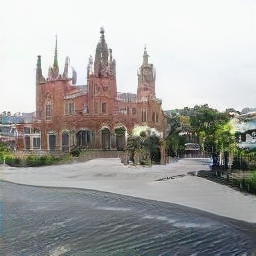

In [79]:
import torch
from ganpaint import nethook, setting, renormalize, zdataset, paintwidget, show
from ganpaint.labwidget import Button

# Load a generator, and paint random image number 20 in a widget.
G = nethook.InstrumentedModel(setting.load_proggan('church')).cuda()
z = zdataset.z_sample_for_model(G)[20][None].cuda()

# Whenever the widget changes, call "changed" to edit the layer and repaint

class GanPaintWidget:
    def __init__(self, G, z, layer, unit_groups):
        self.G = G
        self.z = z
        self.layer = layer
        self.canvas = paintwidget.PaintWidget(image=renormalize.as_url(G(z)[0]))
        self.unit_groups = unit_groups
        self.reset = Button('reset')
        self.reset.on('click', self.do_reset)
        def setup_button(mode):
            button = Button(mode)
            def setmode():
                self.mode = mode
            button.on('click', setmode)
            setattr(self, mode, button)
        for i, k in enumerate(unit_groups):
            setup_button(k)
            if i == 0:
                self.mode = k
        self.canvas.on('mask', self.painted)
    def do_reset(self):
        def editrule(x):
            return x
        self.G.edit_layer('layer4', rule=editrule)
        self.canvas.mask = ''
    def painted(self, mask):
        logging.debug('got painted call')
        a = (renormalize.from_url(mask, target='pt', size=(8,8))[0]
             if mask else torch.zeros(8,8))
        units = self.unit_groups[self.mode]
        logging.debug('units are ' + repr(units))
        def editrule(x, imodel, **buffers):
            x[:,units] += (a * 20.0).to(x.device)
            return x
        self.G.edit_layer('layer4', rule=editrule)
        self.canvas.image = renormalize.as_url(self.G(self.z)[0])
    def _repr_html_(self):
        return show.html([(self.canvas, [(self.reset,)] + [
                (getattr(self, k),) for k in self.unit_groups])])
gpw = GanPaintWidget(
    nethook.InstrumentedModel(setting.load_proggan('church')).cuda(),
    zdataset.z_sample_for_model(G)[20][None].cuda(),
    dict(tree=[119, 125, 157, 195, 365, 374, 418, 426, 408, 3, 297, 322, 343]))
show(gpw)


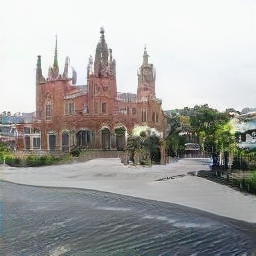

In [63]:
gpw.canvas

In [6]:
from ganpaint import paintwidget
pw = paintwidget.PaintWidget(image='http://wednesday.csail.mit.edu/davidbau/encoder/results/image9-mask.png')
display(pw)